In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
data = pd.read_csv('data.csv')

data.dropna(inplace=True)
data['Date and Hour'] = data['Date and Hour'].apply(lambda x: datetime.strptime(x[:-6], "%Y-%m-%d %H:%M:%S"))
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

data.head()


data['StartHourNum'] = data['Date and Hour'].apply(lambda x: x.hour)
data['Year'] = data['Date and Hour'].apply(lambda x: x.year)
data['MonthNum'] = data['Date and Hour'].apply(lambda x: x.month)
data['Week'] = data['Date and Hour'].apply(lambda x: x.week)
data['WeekOfDay'] = data['Date and Hour'].apply(lambda x: x.day_of_week)
data = data.set_index('Date and Hour')
data = data.sort_index()
data.head()

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName,StartHourNum,Year,MonthNum,Week,WeekOfDay
Date and Hour,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01,0:00:00,1:00:00,Solar,0.0,1,Wednesday,January,0,2020,1,1,2
2020-01-01 00:00:00,2020-01-01,0:00:00,1:00:00,Wind,3549.0,1,Wednesday,January,0,2020,1,1,2
2020-01-01 01:00:00,2020-01-01,1:00:00,2:00:00,Wind,2952.0,1,Wednesday,January,1,2020,1,1,2
2020-01-01 01:00:00,2020-01-01,1:00:00,2:00:00,Solar,0.0,1,Wednesday,January,1,2020,1,1,2
2020-01-01 02:00:00,2020-01-01,2:00:00,3:00:00,Wind,2722.0,1,Wednesday,January,2,2020,1,1,2


In [25]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [42]:
past = 720
future = 1
df = data[data['Source'] == 'Wind'][['Production']].sort_index().reset_index()

split = 0.715
train_split = int(split * len(df))
print(train_split)
train = df[: train_split]
val = df[train_split:]

train  = df['Production'][:720]
# train[:720]
test = df['Production'][720:750]
test

21380


720    9119.0
721    8732.0
722    8392.0
723    8011.0
724    7729.0
725    7225.0
726    6639.0
727    6057.0
728    5738.0
729    5748.0
730    6075.0
731    6249.0
732    6470.0
733    6517.0
734    6351.0
735    6192.0
736    6308.0
737    6688.0
738    7252.0
739    7823.0
740    8039.0
741    8390.0
742    8280.0
743    8275.0
744    8312.0
745    8581.0
746    8881.0
747    9113.0
748    9145.0
749    9254.0
Name: Production, dtype: float64

In [38]:
model= SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
model_fit = model.fit()

model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83020D+00    |proj g|=  9.52257D-02

At iterate    5    f=  6.75703D+00    |proj g|=  6.49098D-03

At iterate   10    f=  6.75625D+00    |proj g|=  1.89430D-03

At iterate   15    f=  6.67818D+00    |proj g|=  4.20168D-02

At iterate   20    f=  6.65965D+00    |proj g|=  1.96498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   7.377D-06   6.660D+00
  F =   6.6596461579082860     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Production   No. Observations:                  720
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4794.945
Date:                            Tue, 01 Oct 2024   AIC                           9599.890
Time:                                    12:09:01   BIC                           9622.696
Sample:                                         0   HQIC                          9608.702
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6526      0.028     22.965      0.000       0.597       0.708
ma.L1          0.3911      0.034     11.459      0.000       0.324       0.458
ar.S.L12      -0.0306      0.037     -0.839      0.401      -0.102       0.041
ma.S.L12      -0.9997      1.792     -0.558      0.577      -4.512       2.513
sigma2      4.225e+04   7.51e+04      0.563      0.574   -1.05e+05    1.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                20.71
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

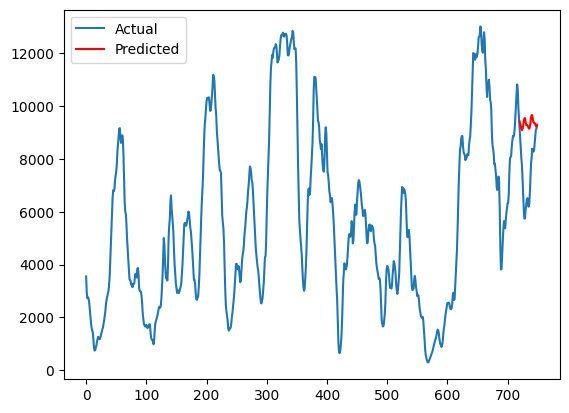

In [44]:
forecast = model_fit.forecast(steps=len(test))

plt.plot(df['Production'][:750], label='Actual')
plt.plot(forecast, label='Predicted', color='red')
plt.legend()
plt.show()